# Todo
1. Label plots
1. Improve plot2Maps by adding labels and colorbar/range options
1. Save and easily import some standard pre-generated maps
1. Optimise lensing code.
1. Change averager to rings of Fourier map.
1. Averager accepts multiple realisations.
1. Optimise QE by reusing computed arrays.
1. Minimum variance weighting of several estimators.

# How it works
* Always begin with `getCambSpectra`.
* Load spectra into a `CMBSpectra` for interpolation.
* Generate `CMBMap`s or a combined `TEB` using `CMBSpectra.generatePrimordialMaps`.
* Detector noise application are defined by `Detector`.
* Lens using `lensTEB`.

In [1]:
from cmb_simulation import *

In [2]:
# getCambSpectra
powers = getCambSpectra()
print(powers.keys())
print(powers['unlensed_scalar'].shape)

dict_keys(['total', 'unlensed_scalar', 'unlensed_total', 'lensed_scalar', 'tensor', 'lens_potential'])
(7051, 4)


# Basics

In [22]:
# get_ls
d = 0.1
N = 9
lx, ly = get_ls(d, N)
print(lx * d*N/2/np.pi)
print(ly * d*N/2/np.pi)
# validate:
# kx goes horizontally (second coord)
# ky goes vertically (first coord)

[[0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]]
[[ 0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.]
 [ 3.  3.  3.  3.  3.]
 [ 4.  4.  4.  4.  4.]
 [-4. -4. -4. -4. -4.]
 [-3. -3. -3. -3. -3.]
 [-2. -2. -2. -2. -2.]
 [-1. -1. -1. -1. -1.]]


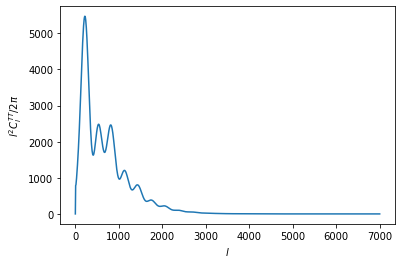

In [35]:
# Spectrum.plot
cmb = CMBSpectra(powers)
ls = np.linspace(1, 7000, 1000)
cmb.TT.plot(ls, scale2)
plt.xlabel('$l$')
plt.ylabel('$l^2C^{TT}_l/2\pi$')
plt.show()
# validate: see CAMB demo

In [13]:
# elemTensorProd
arr1 = np.random.random((10, 15, 2, 3))
arr2 = np.random.random((10, 15, 4, 5))
prod = elemTensorProd(arr1, arr2)
prod[5,5,1,2,3,4] - arr1[5,5,1,2]*arr2[5,5,3,4]
# validate: 0

0.0

In [12]:
# dotVec
arr = np.random.random((10, 15, 5, 5))
vec = np.random.random((10, 15, 5))
dv = dotVec(arr, vec)
dv2 = np.array([[arr[i,j]@vec[i,j]@vec[i,j] for j in range(15)] for i in range(10)])
dv[5,5] - dv2[5,5]
# validate: 0

0.0

In [16]:
# irfft2
d = 0.0004
N = 200
cmb = CMBSpectra(powers)
teb = cmb.generatePrimordialMaps(d, N)
p = cmb.generateLensingPotential(d, N)
stacked = np.zeros((N, N//2+1, 2, 2), dtype='complex_')
stacked[:,:,0,0] = teb.T.f
stacked[:,:,0,1] = teb.E.f
stacked[:,:,1,0] = teb.B.f
stacked[:,:,1,1] = p.f

np.max(np.abs(irfft2(stacked) - np.fft.irfft2(stacked, axes=(0, 1))))
# validate: 0

0.0

In [ ]:
# convolution
d = 0.0004
N = 200
cmb = CMBSpectra(powers)
teb = cmb.generatePrimordialMaps(d, N)
p = cmb.generateLensingPotential(d, N)
arr1 = teb.T.f
arr2 = p.f

# Generating maps by sampling

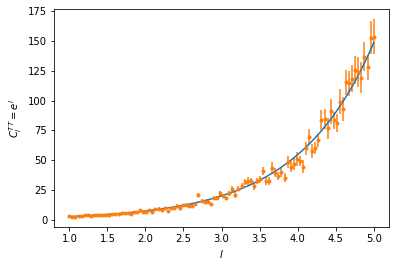

In [24]:
spec = Spectrum(np.exp)
ls = np.linspace(1, 5, 100)
samples = np.array([spec.sample(ls) for _ in range(100)])
means = np.mean((samples*samples.conj()).real, axis=0)
stds = np.std((samples*samples.conj()).real, axis=0)/np.sqrt(100)

spec.plot(ls)
plt.errorbar(ls, means, stds, fmt='.')
plt.xlabel('$l$')
plt.ylabel('$C^{TT}_l = e^l$')
plt.show()
# validate: line goes through points, error bars make sense

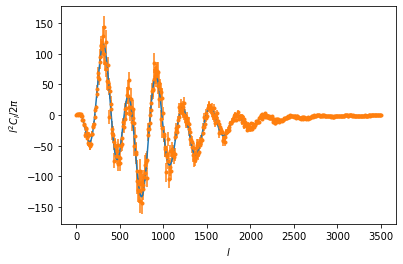

In [25]:
# choleskyUnlensed, sampleCov
cmb = CMBSpectra(powers)
ls = np.linspace(0, 3500, 500)
chol = cmb.choleskyUnlensed(ls)
samples = np.array([sampleCov(chol) for _ in range(100)])
means_TT = np.mean((samples[:,:,0]*samples[:,:,0].conj()).real, axis=0)
stds_TT = np.std((samples[:,:,0]*samples[:,:,0].conj()).real, axis=0)/np.sqrt(100)
means_EE = np.mean((samples[:,:,1]*samples[:,:,1].conj()).real, axis=0)
stds_EE = np.std((samples[:,:,1]*samples[:,:,1].conj()).real, axis=0)/np.sqrt(100)
means_TE = np.mean((samples[:,:,0]*samples[:,:,1].conj()).real, axis=0)
stds_TE = np.std((samples[:,:,0]*samples[:,:,1].conj()).real, axis=0)/np.sqrt(100)

# cmb.TT.plot(ls, lambda l: l**2/(2*np.pi))
# plt.errorbar(ls, means_TT*ls**2/(2*np.pi), stds_TT*ls**2/(2*np.pi), fmt='.')
# cmb.EE.plot(ls, lambda l: l**2/(2*np.pi))
# plt.errorbar(ls, means_EE*ls**2/(2*np.pi), stds_EE*ls**2/(2*np.pi), fmt='.')
cmb.TE.plot(ls, lambda l: l**2/(2*np.pi))
plt.errorbar(ls, means_TE*ls**2/(2*np.pi), stds_TE*ls**2/(2*np.pi), fmt='.')
plt.xlabel('$l$')
plt.ylabel('$l^2C_l/2\pi$')
plt.show()
# validate: curves passes through points, error bars look reasonable

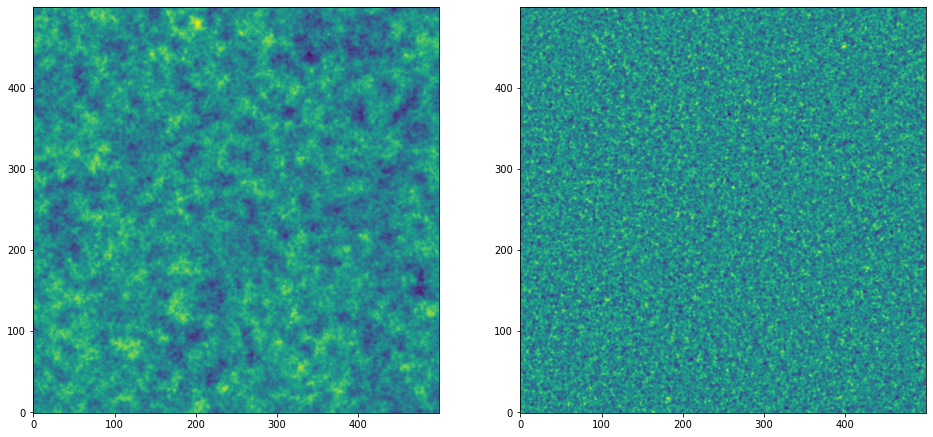

In [5]:
# generatePrimordialMaps, CMBMap.plot
d = 0.001
N = 500
cmb = CMBSpectra(powers)
teb = cmb.generatePrimordialMaps(d, N)

plot2Maps(teb.T.r, teb.E.r)

In [6]:
# temperature fluctuation
d = 0.001
N = 500
cmb = CMBSpectra(powers)
teb = cmb.generatePrimordialMaps(d, N)

np.std(teb.T.r)
# validate: stdev ~ 100 muK

102.6345406560074

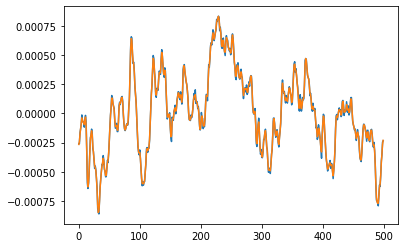

1.8164197875631547

In [7]:
# grad, RMS lensing deflection
d = 0.001
N = 500
cmb = CMBSpectra(powers)
p = cmb.generateLensingPotential(d, N)

px, py = grad(p)
py_np, px_np = np.gradient(p.r, d)

plt.plot(px.r[100])
plt.plot(px_np[100])
plt.show()

np.sqrt(np.mean(px.r**2 + py.r**2)) / np.pi*180*60
# validate: curves overlap
# ~2 arcmin

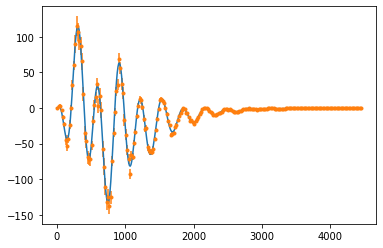

In [8]:
# generatePrimordialMaps, binnedCorrelation
d = 0.001
N = 500
cmb = CMBSpectra(powers)
teb = cmb.generatePrimordialMaps(d, N)

cmb.TE.plot(np.linspace(1, 4200, 400), lambda l: l**2/(2*np.pi))
avg = binnedCorrelation(teb.T, teb.E)
avg.plot(lambda l: l**2/(2*np.pi), fmt='.')
# validate: curve passes through points, error bars are reasonable

In [9]:
# getTQU
d = 0.001
N = 500
cmb = CMBSpectra(powers)
teb = cmb.generatePrimordialMaps(d, N)
tqu = teb.getTQU()

lx, ly = get_ls(d, N)
phi_l = np.arctan2(ly, lx)
P1 = teb.E.f + 1j*teb.B.f
P2 = np.exp(-2j*phi_l) * (tqu.Q.f + 1j*tqu.U.f)
np.max(((P1-P2)*(P1-P2).conj()).real)
# validate: difference is tiny

6.617444900424221e-23

In [10]:
# getTEB
d = 0.001
N = 500
cmb = CMBSpectra(powers)
teb = cmb.generatePrimordialMaps(d, N)
tqu = teb.getTQU()
teb2 = tqu.getTEB()

np.max(teb.E.r-teb2.E.r)-np.min(teb.E.r-teb2.E.r)
# validate: difference is tiny

2.220446049250313e-14

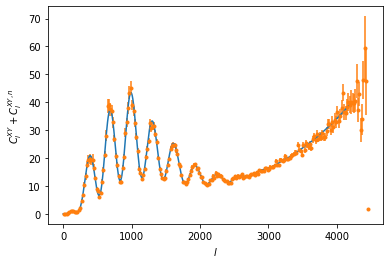

In [34]:
# addNoise
d = 0.001
N = 500
cmb = CMBSpectra(powers)
teb = cmb.generatePrimordialMaps(d, N)
simons = Detector(*simons_params)
teb_obs = simons.addNoise(teb)

(cmb.EE + simons.EEn).plot(np.linspace(1, 4200, 500), lambda l: l**2/(2*np.pi))
teb_obs.E.binSpectrum().plot(lambda l: l**2/(2*np.pi), fmt='.')
plt.xlabel('$l$')
plt.ylabel('$C^{XY}_l + C^{XY,n}_l$')
plt.show()
# validate: curves match and error bars are reasonable

# Lensing

In [3]:
d = 0.0004
N = 1000
cmb = CMBSpectra(powers)
teb = cmb.generatePrimordialMaps(d, N)
p = cmb.generateLensingPotential(d, N)

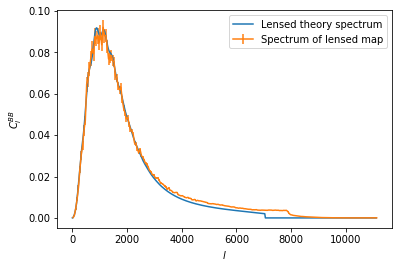

In [4]:
# Lensing by cubic interpolation
teb_len1 = lensTEB(teb, p, fun=lensInterp)

ls = np.linspace(1, np.max(teb_len1.ml), 500)
cmb.BB_len.plot(ls, lambda l: l**2/(2*np.pi), label='Lensed theory spectrum')
teb_len1.B.binSpectrum(delta=50).plot(lambda l: l**2/(2*np.pi), label='Spectrum of lensed map')
plt.xlabel('$l$')
plt.ylabel('$C^{BB}_l$')
plt.legend()
plt.show()
# 2.5s

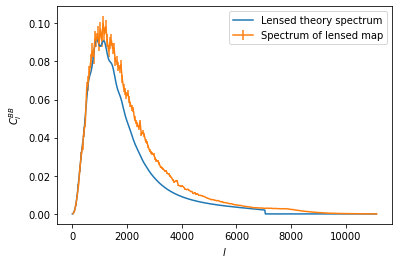

In [5]:
# Lensing by simple Taylor expansion
teb_len2 = lensTEB(teb, p, fun=lensTaylor)

ls = np.linspace(1, np.max(teb_len2.ml), 500)
cmb.BB_len.plot(ls, lambda l: l**2/(2*np.pi), label='Lensed theory spectrum')
teb_len2.B.binSpectrum(delta=50).plot(lambda l: l**2/(2*np.pi), label='Spectrum of lensed map')
plt.xlabel('$l$')
plt.ylabel('$C^{BB}_l$')
plt.legend()
plt.show()
# 1.9s, worse convergence than interp

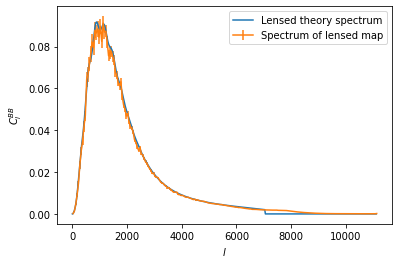

In [6]:
# Lensing by simple Taylor expansion
teb_len3 = lensTEB(teb, p, fun=lensTaylorNearest)

ls = np.linspace(1, np.max(teb_len3.ml), 500)
cmb.BB_len.plot(ls, lambda l: l**2/(2*np.pi), label='Lensed theory spectrum')
teb_len3.B.binSpectrum(delta=50).plot(lambda l: l**2/(2*np.pi), label='Spectrum of lensed map')
plt.xlabel('$l$')
plt.ylabel('$C^{BB}_l$')
plt.legend()
plt.show()
# 10.4s, better convergence than interp

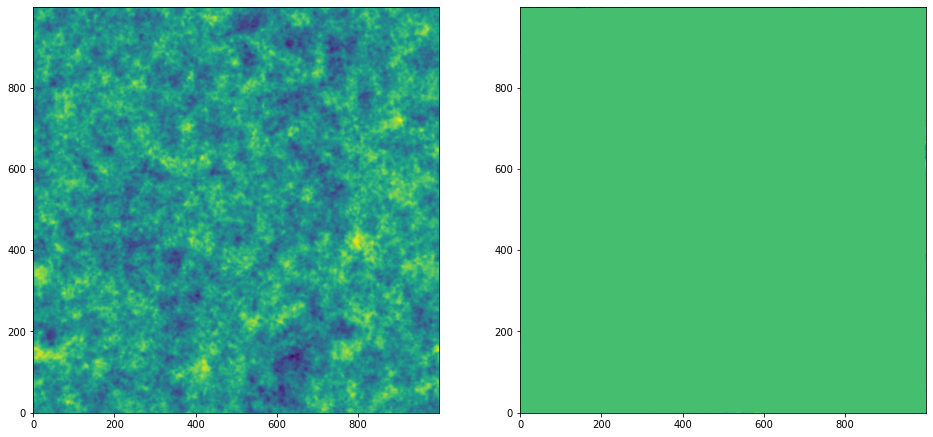

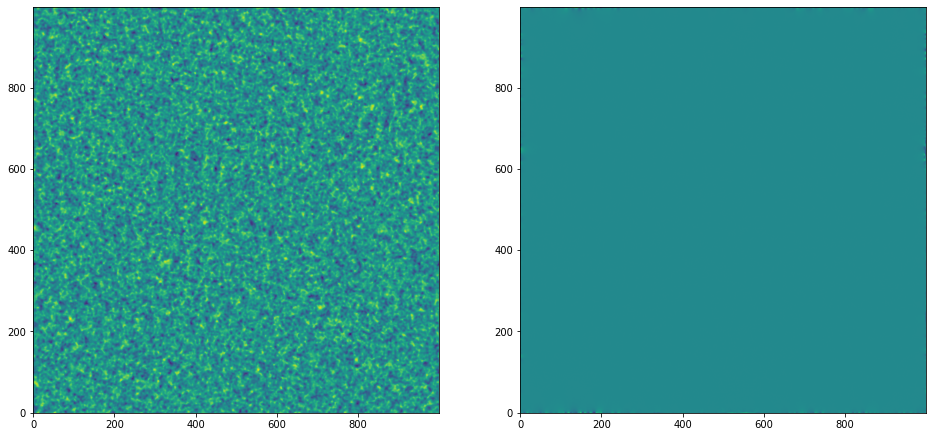

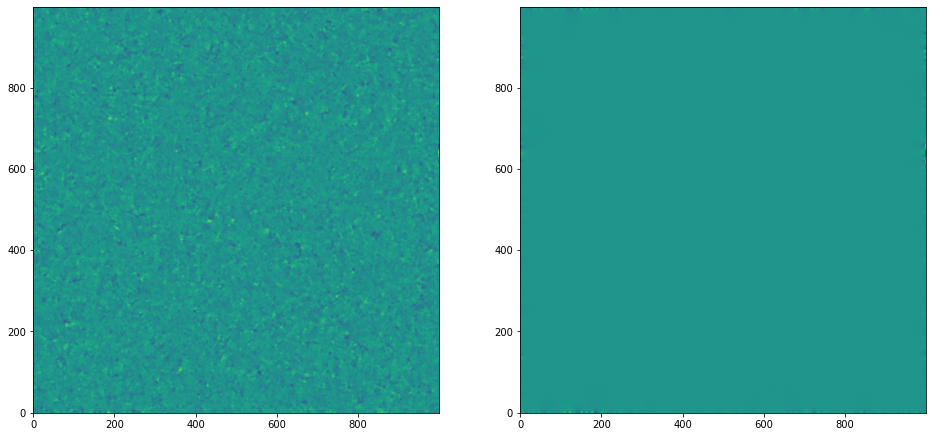

In [13]:
# Interp and Taylor(Nearest) are consistent with each other
plot2Maps(teb_len1.T.r, teb_len3.T.r-teb_len1.T.r)
plot2Maps(teb_len1.E.r, teb_len3.E.r-teb_len1.E.r)
plot2Maps(teb_len1.B.r, teb_len3.B.r-teb_len1.B.r)
# validate: RHS all empty

# Quadratic estimator

In [7]:
d = 1/60/180*np.pi
N = 800
cmb = CMBSpectra(powers)
teb = cmb.generatePrimordialMaps(d, N)
p = cmb.generateLensingPotential(d, N)
detector = Detector(*cmb_s4_params)
teb_obs = detector.addNoise(teb)
teb_len = lensTEB(teb, p, lensTaylorNearest)
teb_len_obs = detector.addNoise(teb_len)

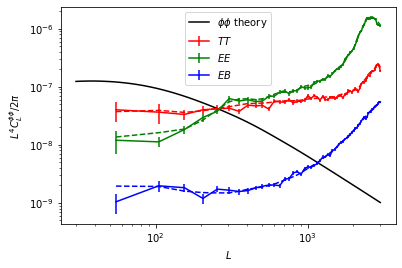

In [8]:
# unlensed
lmin = 30
lmax = 3000
qe_unl = LensingEstimator(cmb, teb_obs, detector, lensed=False)
params = {'TT': 'r', 'EE': 'g', 'EB': 'b'}
qe_unl_XY = dict()
delta = 50

cmb.pp.plot(np.logspace(np.log10(lmin), np.log10(lmax)), scale=scale4, fmt='k-', label='$\phi\phi$ theory') # theory phi-phi spectrum
for key, param in params.items():
    qe_unl_XY[key] = qe_unl.evaluateQE(key, lmin, lmax)
    qe_unl_XY[key].binSpectrum(delta, lmin, lmax).plot(scale=scale4, fmt=param+'-', label='$%s$'%key) # estimator auto spectrum
    qe_unl.plotNoise(key, lmin, lmax, delta, scale=scale4, errorbars=False, logaxis='both', fmt=param+'--') # reconstruction noise spectrum

plt.xlabel('$L$')
plt.ylabel('$L^4 C^{\phi\phi}_L / 2\pi$')
plt.legend()
plt.show()
# validate: solid lines (estimator auto spectra) follow dashed lines (reconstruction noise)
# 15.3s

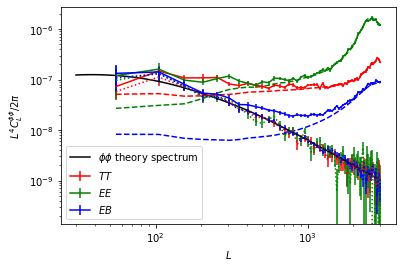

In [9]:
# lensed
lmin = 30
lmax = 3000
qe_len = LensingEstimator(cmb, teb_len_obs, detector, lensed=True)
params = {'TT': 'r', 'EE': 'g', 'EB': 'b'}
qe_len_XY = dict()
delta = 50

cmb.pp.plot(np.logspace(np.log10(lmin), np.log10(lmax)), scale=scale4, fmt='k-', label='$\phi\phi$ theory spectrum') # theory phi-phi spectrum
for key, param in params.items():
    qe_len_XY[key] = qe_len.evaluateQE(key, lmin, lmax)
    qe_len_XY[key].binSpectrum(delta, lmin, lmax).plot(scale=scale4, fmt=param+'-', label='$%s$'%key) # estimator auto spectrum
    qe_len.plotNoise(key, lmin, lmax, delta, scale=scale4, errorbars=False, logaxis='both', fmt=param+'--') # reconstruction noise spectrum
    binnedCorrelation(p, qe_len_XY[key], delta, lmin, lmax).plot(scale=scale4, fmt=param+':')

plt.xlabel('$L$')
plt.ylabel('$L^4 C^{\phi\phi}_L / 2\pi$')
plt.legend()
plt.show()
# validate: solid lines (estimator auto spectra) follow dashed lines (reconstruction noise) at high L
# and black solid line (phi-phi theory spectrum) at low L
# dotted lines (phi-estimator cross correlation) follow black line
# 15.4s

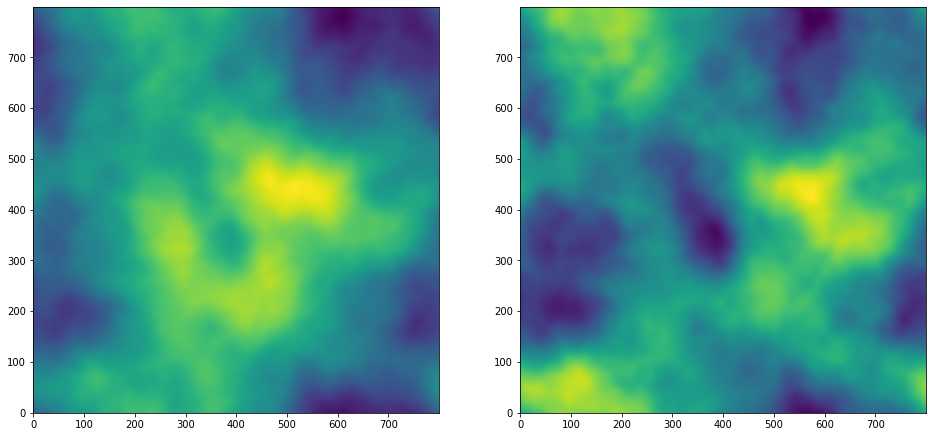

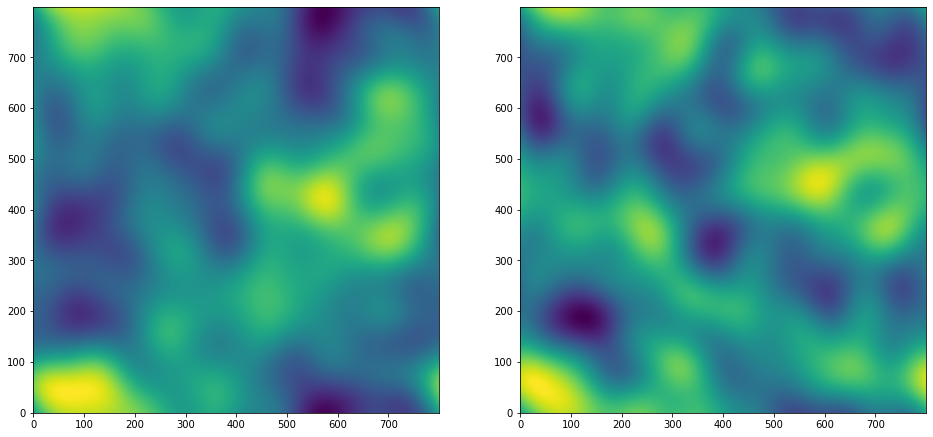

In [10]:
plot2Maps(p.r, qe_len_XY['EB'].masked(lmin, 800).r)
plot2Maps(qe_len_XY['EE'].masked(lmin, 200).r, qe_len_XY['TT'].masked(lmin, 200).r)

# Rotation quadratic estimator

In [3]:
C_aa = getCaa()

In [4]:
f_sub = 0.8
d = 3/60/180*np.pi
N = 512
cmb = CMBSpectra(powers)
teb = cmb.generatePrimordialMaps(d, N)
p = cmb.generateLensingPotential(d, N)
aa_spec = Spectrum(C_aa(0.2))
a = aa_spec.generateMap(d, N)
detector = Detector(*cmb_s4_params)
teb_obs = detector.addNoise(teb) # no lensing, no rotation
teb_len = lensTEB(teb, p, lensTaylorNearest)
teb_len_obs = detector.addNoise(teb_len) # lensing, no rotation
teb_rot = rotateTEB(teb, a)
teb_rot_obs = detector.addNoise(teb_rot) # rotation, no lensing
teb_len_rot = rotateTEB(teb_len, a)
teb_len_rot_obs = detector.addNoise(teb_len_rot) # rotation and lensing

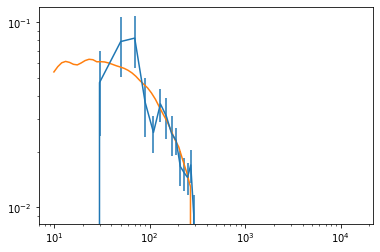

In [32]:
# rotation realisation from spectrum
a.binSpectrum(20).plot(scale2deg, logaxis='both')
aa_spec.plot(np.logspace(1, 3), scale=scale2deg)

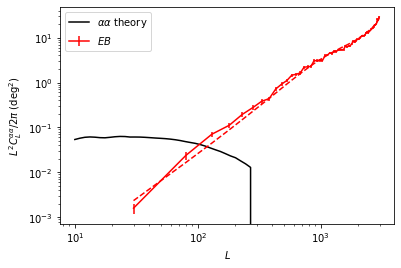

In [33]:
# unrotated
lmin = 5
lmax = 3000
qe_unr = RotationEstimator(cmb, teb_len_obs, detector, lensed=True)
params = {'EB': 'r'}
qe_unr_XY = dict()
delta = 50

aa_spec.plot(np.logspace(1, 3), scale=scale2deg, fmt='k-', label=r'$\alpha\alpha$ theory') # theory alpha-alpha spectrum
for key, param in params.items():
    qe_unr_XY[key] = qe_unr.evaluateQE(key, lmin, lmax)
    qe_unr_XY[key].binSpectrum(delta, lmin, lmax).plot(scale=scale2deg, fmt=param+'-', label='$%s$'%key) # estimator auto spectrum
    qe_unr.plotNoise(key, lmin, lmax, delta, scale=scale2deg, errorbars=False, logaxis='both', fmt=param+'--') # reconstruction noise spectrum

plt.xlabel('$L$')
plt.ylabel(r'$L^2 C^{\alpha\alpha}_L / 2\pi$ (deg$^2$)')
plt.legend()
plt.show()
# validate: solid lines (estimator auto spectra) follow dashed lines (reconstruction noise)
# 15.3s

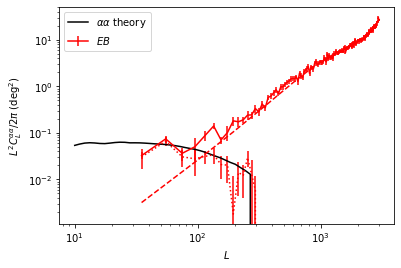

In [34]:
# rotated
lmin = 5
lmax = 3000
qe_rot = RotationEstimator(cmb, teb_len_rot_obs, detector, lensed=True)
params = {'EB': 'r'}
qe_rot_XY = dict()
delta = 20

aa_spec.plot(np.logspace(1, 3), scale=scale2deg, fmt='k-', label=r'$\alpha\alpha$ theory') # theory alpha-alpha spectrum
for key, param in params.items():
    qe_rot_XY[key] = qe_rot.evaluateQE(key, lmin, lmax)
    qe_rot_XY[key].binSpectrum(delta, lmin, lmax).plot(scale=scale2deg, fmt=param+'-', label='$%s$'%key) # estimator auto spectrum
    qe_rot.plotNoise(key, lmin, lmax, delta, scale=scale2deg, errorbars=False, logaxis='both', fmt=param+'--') # reconstruction noise spectrum
    binnedCorrelation(a, qe_rot_XY[key], delta, lmin, lmax).plot(scale=scale2deg, fmt=param+':')

plt.xlabel('$L$')
plt.ylabel(r'$L^2 C^{\alpha\alpha}_L / 2\pi$ (deg$^2$)')
plt.legend()
plt.show()
# validate: solid lines (estimator auto spectra) follow dashed lines (reconstruction noise)

# Cutom rotation field

In [ ]:
C_aa = getCaa()

In [88]:
d = 1/60/180*np.pi
N = 512
a = CMBMap(d, N, real=rotationFromCircularStrings(N, 1, 400, 50))
cmb = CMBSpectra(powers)
teb = cmb.generatePrimordialMaps(d, N)
p = cmb.generateLensingPotential(d, N)
aa_spec = Spectrum(C_aa(0.2))
detector = Detector(*cmb_s4_params)
teb_obs = detector.addNoise(teb) # no lensing, no rotation
teb_len = lensTEB(teb, p, lensTaylorNearest)
teb_len_obs = detector.addNoise(teb_len) # lensing, no rotation
teb_rot = rotateTEB(teb, a)
teb_rot_obs = detector.addNoise(teb_rot) # rotation, no lensing
teb_len_rot = rotateTEB(teb_len, a)
teb_len_rot_obs = detector.addNoise(teb_len_rot) # rotation and lensing

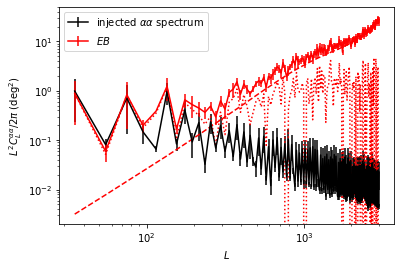

In [89]:
# rotated
lmin = 5
lmax = 3000
qe_rot = RotationEstimator(cmb, teb_len_rot_obs, detector, lensed=True)
params = {'EB': 'r'}
qe_rot_XY = dict()
delta = 20

a.binSpectrum(20, 5, 3000).plot(scale2deg, fmt='k-', label=r'injected $\alpha\alpha$ spectrum') # injected alpha-alpha spectrum
for key, param in params.items():
    qe_rot_XY[key] = qe_rot.evaluateQE(key, lmin, lmax)
    qe_rot_XY[key].binSpectrum(delta, lmin, lmax).plot(scale=scale2deg, fmt=param+'-', label='$%s$'%key) # estimator auto spectrum
    qe_rot.plotNoise(key, lmin, lmax, delta, scale=scale2deg, errorbars=False, logaxis='both', fmt=param+'--') # reconstruction noise spectrum
    # binnedCorrelation(a, qe_rot_XY[key], delta, lmin, lmax).plot(scale=scale2deg, fmt=param+':')

### estimator auto spectrum minus noise spectrum
binned = qe_rot_XY['EB'].binSpectrum(delta, lmin, lmax)
N_avg = Averager(d, qe_rot.noise['EB'], delta, lmin, lmax)
N_fun = interp1d(N_avg.ls, N_avg.means)
plt.plot(binned.ls, (binned.means - N_fun(binned.ls)) * scale2deg(binned.ls), 'r:')

plt.xlabel('$L$')
plt.ylabel(r'$L^2 C^{\alpha\alpha}_L / 2\pi$ (deg$^2$)')
plt.legend()
plt.show()
# validate: solid lines (estimator auto spectra) follow dashed lines (reconstruction noise)

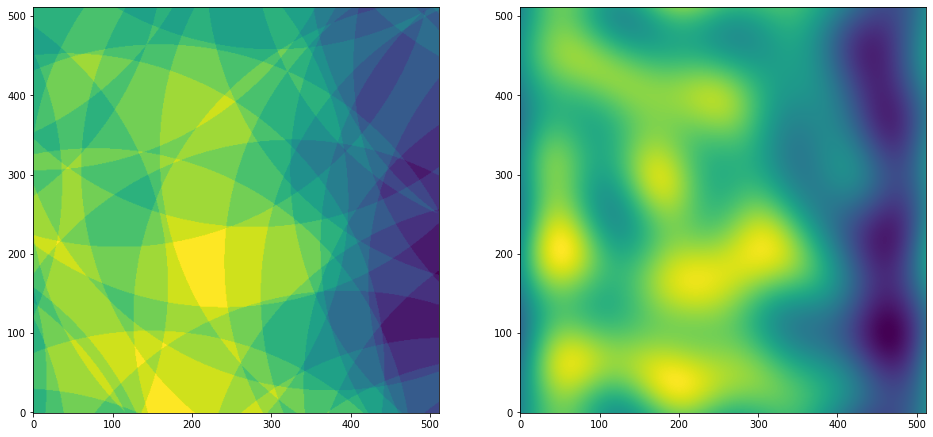

In [90]:
lmask = modl(*get_ls(d, N)) < 200
qe_rot_EB = np.fft.irfft2(qe_rot_XY['EB'].f * lmask, s=(N, N))
plot2Maps(a.r, qe_rot_EB)

# Testing